<span style="color:#000000; font-size:1.2em; text-align:right">Data Scientist II Technical Challenge</span>

<span style="color:#e01760; font-size:2em; align=center">Task 4: Real-world Scenario</span>

<font color="#6E6E6E" align="center">Cristina M. Sánchez Maíz | csmaiz@gmail.com | [LinkedIn](https://www.linkedin.com/in/csmaiz/) </font> 

**Tasks:** 

Consider the following business problem:
Your company wants to improve customer satisfaction by understanding the main topics and sentiments expressed in customer reviews. Your task is to:
- Use topic modeling to identify the main topics in the customer reviews.
- Summarize the findings and suggest actionable insights for business improvements. 

**Deliverables:**
- Explanation of the topic modeling process.
- Summary of the main topics identified.
- Actionable insights based on the analysis.

# Import libraries

In [114]:
# Libraries for NLP
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud



from IPython.display import display, HTML


import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import Phrases, LdaModel
from gensim.utils import simple_preprocess

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
import torch
from transformers import DistilBertTokenizer, DistilBertModel


import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [115]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [116]:
pd.set_option('display.max_colwidth', None) # avoid truncate columns content
from IPython.display import display, HTML

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))


# Load dataset


In [117]:
df = pd.read_csv("../output/Task3/reviews_with_scores.csv",delimiter=",")
df[["review_text", "vader_label", "vader_label_3categ", "bert_label", "bert_label_3categ", "bert_score"]].drop_duplicates()

,review_text,vader_label,vader_label_3categ,bert_label,bert_label_3categ,bert_score
0,"Terrible service, will not buy from here again.",negative,negative,negative,negative,0.001188
1,"Average quality, you get what you pay for.",negative,neutral,positive,positive,0.591803
2,"Great product, very satisfied with the quality and performance.",positive,positive,positive,positive,0.999857
3,"Very disappointed with the product, not as described.",negative,negative,negative,negative,0.000211
4,"Excellent service, highly recommend!",positive,positive,positive,positive,0.999873
5,The item arrived damaged and customer service was unhelpful.,negative,negative,negative,negative,0.000206
6,Fast delivery and the product works perfectly!,positive,positive,positive,positive,0.999871
8,"The service was acceptable, but could be improved.",positive,positive,negative,neutral,0.028429
9,"Decent product, but there are better options available.",positive,positive,positive,positive,0.979263
12,"Poor quality, would not recommend.",negative,negative,negative,negative,0.000832


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   review_text          980 non-null    object 
 1   preprocessed_review  980 non-null    object 
 2   vader_label          980 non-null    object 
 3   vader_label_3categ   980 non-null    object 
 4   bert_score           980 non-null    float64
 5   bert_label           980 non-null    object 
 6   bert_label_3categ    980 non-null    object 
dtypes: float64(1), object(6)
memory usage: 53.7+ KB


# Topic Modeling

First, topic modeling will be applied to find the main topics within the reviews. By combining topic modeling and sentiment analysis (Part 3), we can gain valuable insights into customer feedback and drive business improvements.

In [137]:
# Only negative reviews are taken into account in order to obtain the issues.
# Remove duplicate reviews before running the clustering since duplicate reviews 
# can skew the clustering results by giving more weight to the repeated texts
df_negative = df[df["bert_label_3categ"] == "negative"].drop_duplicates("review_text").copy()
df_negative["tokens"] = df_negative['preprocessed_review'].apply(lambda pp: pp.split(" "))

## LDA

### Build LDA model

In [138]:
def run_LDA(df, num_topics):

    id2word = Dictionary(df["tokens"])
    corpus = [id2word.doc2bow(text) for text in df["tokens"]]
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=3)

    for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=5):
        print(f"Topic {idx}: {topic}")
        
    return lda_model, corpus, id2word

num_topics_lda=4
lda_model, corpus, id2word = run_LDA(df_negative, num_topics=num_topics)

Topic 0: 0.101*"service" + 0.056*"damaged" + 0.056*"unhelpful" + 0.056*"customer" + 0.056*"item"
Topic 1: 0.122*"would" + 0.122*"poor" + 0.121*"recommend" + 0.121*"quality" + 0.025*"product"
Topic 2: 0.135*"product" + 0.134*"disappointed" + 0.134*"described" + 0.027*"terrible" + 0.027*"quality"
Topic 3: 0.111*"product" + 0.111*"use" + 0.111*"unhappy" + 0.111*"broke" + 0.111*"one"


### Topics visualization

In [139]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(LDAvis_prepared)

In [140]:
pyLDAvis.save_html(LDAvis_prepared, '../output/task4/ldavis.html')

In [141]:
from IPython.display import display, HTML
from IPython.display import IFrame
HTML(filename="../output/task4/ldavis.html")

In [152]:
def get_dominant_topic(lda_model, corpus):
    """
    Determines the dominant topic for a given document.

    Args:
        lda_model: Trained LDA model.
        corpus: Document-term matrix.

    Returns:
        Dominant topic number.
    """
    topic_dist = lda_model[corpus]
    dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
    return dominant_topic


def get_topic_dist(lda_model, corpus):
    """
    Determines the dominant topic for a given document.

    Args:
        lda_model: Trained LDA model.
        corpus: Document-term matrix.

    Returns:
        Dominant topic number.
    """
    topic_dist = lda_model[corpus]
    return topic_dist

df_negative['topic_dist'] = df_negative['tokens'].apply(lambda x: get_topic_dist(lda_model, id2word.doc2bow(x)))
df_negative['topic_lda'] = df_negative['tokens'].apply(lambda x: get_dominant_topic(lda_model, id2word.doc2bow(x))+1) # topic from 1 to num_topics_lda
df_negative[["review_text", "topic_lda", "topic_dist"]].drop_duplicates(["review_text", "topic_lda"])

,review_text,topic_lda,topic_dist
0,"Terrible service, will not buy from here again.",1,"[(0, 0.81208277), (1, 0.0626387), (2, 0.06265337), (3, 0.06262517)]"
3,"Very disappointed with the product, not as described.",3,"[(0, 0.06306807), (1, 0.06256778), (2, 0.81064427), (3, 0.06371989)]"
5,The item arrived damaged and customer service was unhelpful.,1,"[(0, 0.89260703), (1, 0.035797052), (2, 0.035806663), (3, 0.035789233)]"
12,"Poor quality, would not recommend.",2,"[(0, 0.050026365), (1, 0.84985405), (2, 0.0500661), (3, 0.050053418)]"
14,"The product works fine, but took a long time to arrive.",1,"[(0, 0.90466577), (1, 0.0313297), (2, 0.032087594), (3, 0.03191697)]"
15,"The product broke after one use, very unhappy.",4,"[(0, 0.041942965), (1, 0.04171988), (2, 0.04239779), (3, 0.8739394)]"


Future work:

- Tune parameters (number of topics, preprocessing steps, etc.)
- Consider using more advanced topic modeling techniques like Non-Negative Matrix Factorization (NMF) or Latent Semantic Analysis (LSA).


## Large language model

In [143]:
import os
os.environ["http_proxy"]=""
os.environ["https_proxy"]=""

In [144]:

%%time

# ~40 seconds to run

# Code extracted from Hugging face web - https://huggingface.co/distilbert/distilbert-base-uncased
# Load pre-trained model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

'''
Function to get embeddings for a list of texts
function tokenizes the input texts, generates embeddings using a pre-trained model, 
and averages the token embeddings to produce a single vector representation for each document.
''' 
def get_embeddings(texts, model, tokenizer):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

# Generate embeddings for the reviews
embeddings = get_embeddings(df['review_text'].tolist(), model, tokenizer)



CPU times: user 31.6 s, sys: 1.44 s, total: 33.1 s
Wall time: 31.3 s


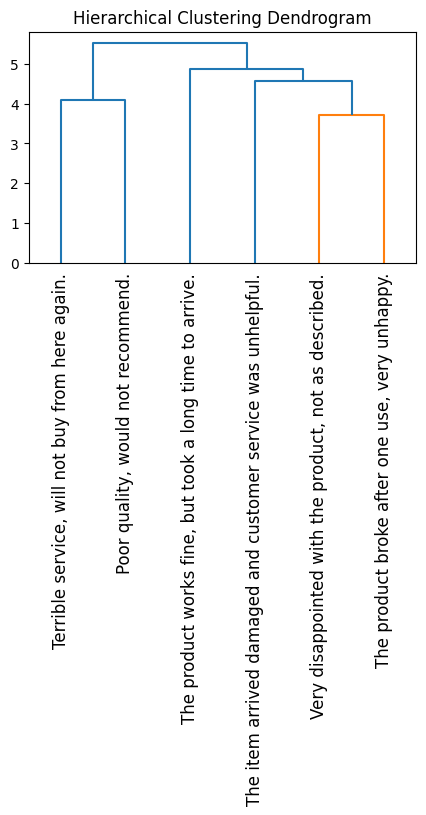

In [229]:
embeddings = get_embeddings(df_negative['review_text'].tolist(), model, tokenizer)

# Apply Hierarchical Clustering
hierarchical_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hierarchical_cluster.fit(embeddings)

# Create the linkage matrix
Z = linkage(embeddings, "ward")


# Plot the dendrogram
plt.figure(figsize=(5, 3))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z, labels = df_negative['review_text'].tolist(), leaf_rotation=90., show_contracted=True)
plt.show()





In [206]:
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Perform-the-Hierarchical-Clustering
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    annot_format = kwargs.pop('annot_format', "%.2f")
        
    ddata = dendrogram(*args, **kwargs, labels = df_negative['review_text'].tolist())

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate(annot_format % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

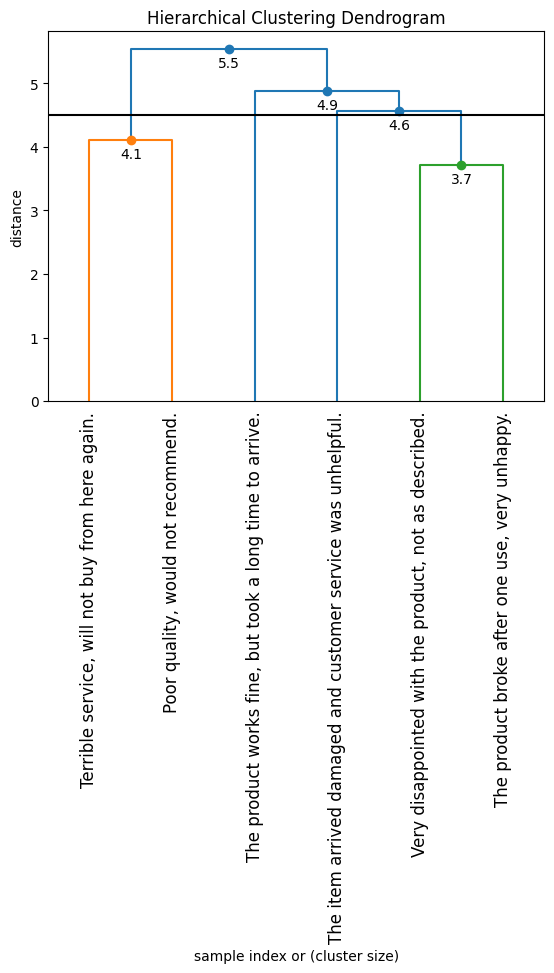

In [227]:
plt.figure()
fancy_dendrogram(
    Z,
    truncate_mode='lastp', # show only the last p merged clusters
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=False,
    annotate_above=1,  # useful in small plots so annotations don't overlap
    annot_format="%.1f",
    max_d = 4.5
)
plt.show()

In [242]:
# Decide the number of clusters by cutting the dendrogram
num_clusters_llm = 4  # Adjust based on the dendrogram
labels = fcluster(Z, 4.11, criterion='distance')
df_negative['topic_llm'] = labels

print(df_negative['topic_llm'].value_counts())
df_negative[["review_text", "topic_llm"]].drop_duplicates()



topic_llm
1    2
2    2
3    1
4    1
Name: count, dtype: int64


,review_text,topic_llm
0,"Terrible service, will not buy from here again.",1
3,"Very disappointed with the product, not as described.",2
5,The item arrived damaged and customer service was unhelpful.,3
12,"Poor quality, would not recommend.",1
14,"The product works fine, but took a long time to arrive.",4
15,"The product broke after one use, very unhappy.",2


# Results

## List of reviews grouped by topic

In [212]:
def list_reviews_by_topic(df, review_col, topic_col):
        for topic, reviews in df_negative.drop_duplicates("review_text").groupby(topic_col):
            print(f"Topic {topic}:")
            for review in df_negative[df_negative[topic_col] == topic]['review_text']:
                print(f" - {review}")

### LDA 
LDA classification is a little bit messy, mixing service, product and delivery issues.

In [236]:
list_reviews_by_topic(df_negative, review_col="review_text", topic_col="topic_lda")

Topic 1:
 - Terrible service, will not buy from here again.
 - The item arrived damaged and customer service was unhelpful.
 - The product works fine, but took a long time to arrive.
Topic 2:
 - Poor quality, would not recommend.
Topic 3:
 - Very disappointed with the product, not as described.
Topic 4:
 - The product broke after one use, very unhappy.


### LLM

Easier to interprete

In [243]:
list_reviews_by_topic(df_negative, review_col="review_text", topic_col="topic_llm")

Topic 1:
 - Terrible service, will not buy from here again.
 - Poor quality, would not recommend.
Topic 2:
 - Very disappointed with the product, not as described.
 - The product broke after one use, very unhappy.
Topic 3:
 - The item arrived damaged and customer service was unhelpful.
Topic 4:
 - The product works fine, but took a long time to arrive.


* Topic 1
corresponds to the customers who won't recommend buying again --> DETRACTORS
* Topic 2:
   - Product Quality issues
   - Negative Feedback on Product Description
* Topic 3:
   - Customer service issues
* Topic 4:
   * Delivery and Shipping Issues

In [283]:

def create_wordcloud(df, text_column, topic_column, title):

    fig=plt.figure(figsize=(12, 6))

    num_topics = df[topic_column].max()
    n_cols=2
    n_rows = int(np.floor(num_topics/n_cols))

    for topic, reviews in df.drop_duplicates(text_column).groupby(topic_column):
        text = ' '.join(reviews[text_column])
        wordcloud_topic = WordCloud(width=800, height=400).generate(' '.join(reviews[text_column]))
        plt.subplot(2, n_rows, topic)
        plt.imshow(wordcloud_topic, interpolation='bilinear', cmap="summer")
        plt.axis('off')
        plt.title('Topic '+str(topic))

    plt.show()

    fig.savefig("../output/task4/wordcloud_{}.png".format(title))



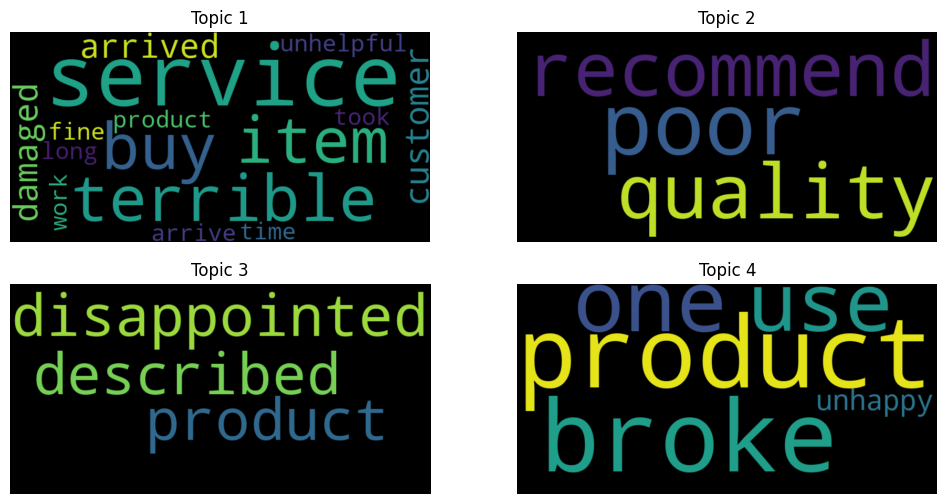

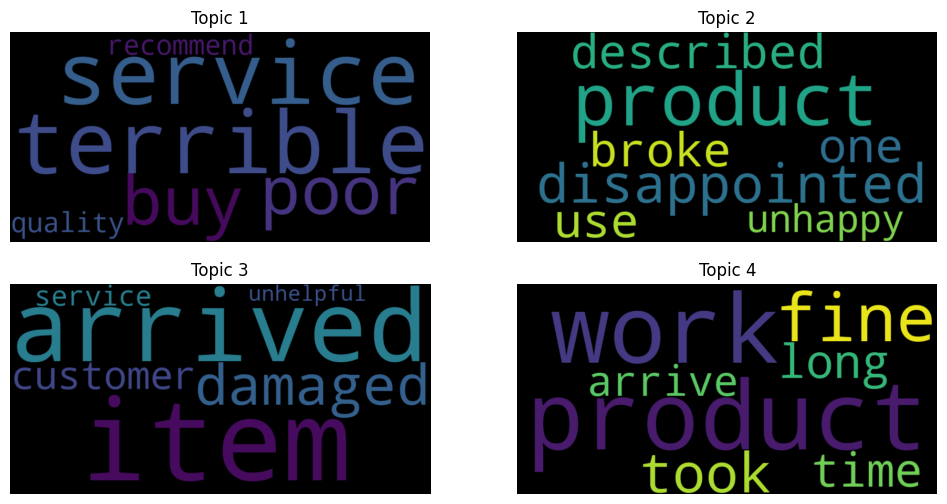

In [282]:
create_wordcloud(df_negative, text_column="preprocessed_review", topic_column="topic_lda", title="LDA")
create_wordcloud(df_negative, text_column="preprocessed_review", topic_column="topic_llm", title="LLM")

### Conclusiones

- Cluster 1 
   * corresponds to the customers who won't recommend buying again --> DETRACTORS
- Cluster 2:
   * Product Quality issues
   * Negative Feedback on Product Description
- Cluster 3:
  * Customer service issues
- Cluster 4:
  * Delivery and Shipping Issues


### Actionable insights based on the analysis.

Based on the identified topics and sentiments, here are some actionable insights for the business:

**Improve Customer Service:**
- Conduct training sessions for customer service representatives to improve their communication skills and responsiveness.
- Implement a better tracking system for customer inquiries to ensure timely responses.

**Enhance Product Descriptions:**
- Review and update product descriptions to ensure they accurately reflect the product features and quality.
- Include more detailed images and customer reviews to set realistic expectations.

**Address Product Quality Issues:**
- Investigate and address any recurring quality issues in the products.
- Consider quality checks and improvements in the production process.


**Streamline Delivery and Shipping:**
- Partner with reliable shipping companies to ensure timely and accurate deliveries.
- Implement a tracking system for customers to monitor their orders in real-time.

Additionally, compare topics over time: Detect trends and emerging issues.
